# 1. Method description

In this method we run 2 executions of KMeans in parallel:
- The first one runs on the full dataset, and performs A, and then B. A -> B
- The second one runs over a subset of the dataset, and performs A, and then B, multiple times. We describe this as a-> b -> a -> b -> ... -> b. We use small a,b to indicate we are using a subset of the dataset.

We then compute:
- L_slow, the average distance from each point to its centroid, using the centroids obtained from the first slow execution
- L_fast, the average distance from each point to its centroid, using the centroids obtained from the second fast execution

Afterwards, we compare L_slow and L_fast: we select the centroids of the lowest one.

The idea is that we can distinguish 2 phases in KMeans:
- the first phase we try to move the centroids from the initialization points near to the respective clusters. We may not need the whole dataset in this phase, and that's why the second and faster execution of KMeans may help
- the second phase start when we almost found the correct position of the centroids and the respective clusters. We are not trying to converge by fixing the last datapoints which are not correctly classified. In this phase is more critical to use the whole dataset, since we need to make small updates of the centroids, which are critical for the convergence.

Let's call L the average distance between datapoints and their centroids.

We expect that:
- L_slow is going to be greater than L_fast in the first phase, so we will benefit from the execution of the second fast run.
- L_slow is going to be less than L_fast in the second phase, so we will no more benefit from the execution of the second fast run. *In this case we may switch to only data parallelism.*

# 2. Measurements L_slow - L_fast 

In this section we study how L_slow - L_fast evolves during the KMeans execution.

As we said before:
We expect that:
- L_slow is going to be greater than L_fast in the first phase, so we will benefit from the execution of the second fast run.
- L_slow is going to be less than L_fast in the second phase, so we will no more benefit from the execution of the second fast run. 

Let's call L_diff = (L_slow - L_fast).

We therefore **expect to see L_diff increasing** during the convergence of KMeans.

> ! **Implementation**: In this measurements the KMeans_sketching algorithm **is not picking the best centroids between the slow execution and the fast execution**. We always keep the centroids of the slow execution, since we just want to see if generally the fast execution gives good prediction of the centroids to use.


---

It is important to have sufficient `n` datapoints in order to have sufficient datapoints also in the **subsampling**.

In [204]:
%load_ext autoreload
%autoreload 2
from utils.helpers import generate_clusters, timeseries_plot, load_datasets
from KMeans import KMeans, getLables, getCentroids, getAvgDist, KMeans_sketching
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.1 Single execution

In [148]:
# set seed = 0
seed = 0
np.random.seed(seed)
# define parameters
n = 100000
d = 2
k = 3
subsample_size = 0.01
# create synthetic dataset
true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)
# set output path
path = './data/sketching/sketching_2_1.csv'

In [149]:
# initialize centroids
np.random.seed(seed)
centroids = X[np.random.choice(n, k, replace=False)]

In [46]:
# slow execution

# A - Assignment step
labels = getLables(X, centroids) 
# B - Update step
centroids = getCentroids(X, labels, k)
# Compute avg distance
L_slow = getAvgDist(X, centroids)

In [47]:
# fast execution

# Subsampling
np.random.seed(seed)
subsample_size = 0.01
mask = np.random.choice([True, False], size=X.shape[0], p=[subsample_size, 1-subsample_size])

# Number of executions n_executions = 1/subsample_size
n_executions = int(np.floor(1/subsample_size))

# Execute a,b n_execution times
for i in range(n_executions):
    # A - Assignment step
    labels = getLables(X[mask], centroids) 
    # B - Update step
    centroids = getCentroids(X[mask], labels, k)
    
# Compute avg distance - we use the whole dataset X now!
L_fast = getAvgDist(X, centroids)

In [48]:
# compute L_diff

L_diff = L_fast - L_slow
L_diff

-0.48168707313829673

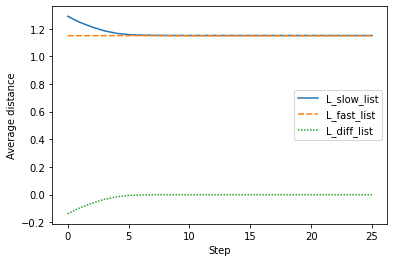

<AxesSubplot:xlabel='Step', ylabel='Average distance'>

In [150]:
# entire execution
labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save=True, path=path)
# read .csv
df = pd.read_csv(path)
# timeseries plot
timeseries_plot(df, xlabel='Step', ylabel='Average distance')

As expected we can see how:
- L_slow is greater than L_fast in the first phase.
- L_slow is less than L_fast in the second phase.

and as consequence **L_diff is increasing**.

## 2.2 Multiple executions - synthetic dataset

### 2.2.1 Varying n, d

We check now if the behaviour of the curves change for different synthetic datasets, with `n` (number of datapoints) and `d` (dimension of each datapoint) varying.

What we expect to see is that the behaviour is going to be the same for any combination of `n` and `d` since:
- `n` only increases the density of datapoints but not their distribution
- in the **synthetic dataset** we have a gaussian distribution in `d` dimensions, whatever is `d`

We take:
- `n` in the range [10^4, 10^6]
- `d` in the range [2, 5]

In [154]:
number_n = 4
number_d = 4
seed = 0
k = 3
run = False
subsample_size = 0.01

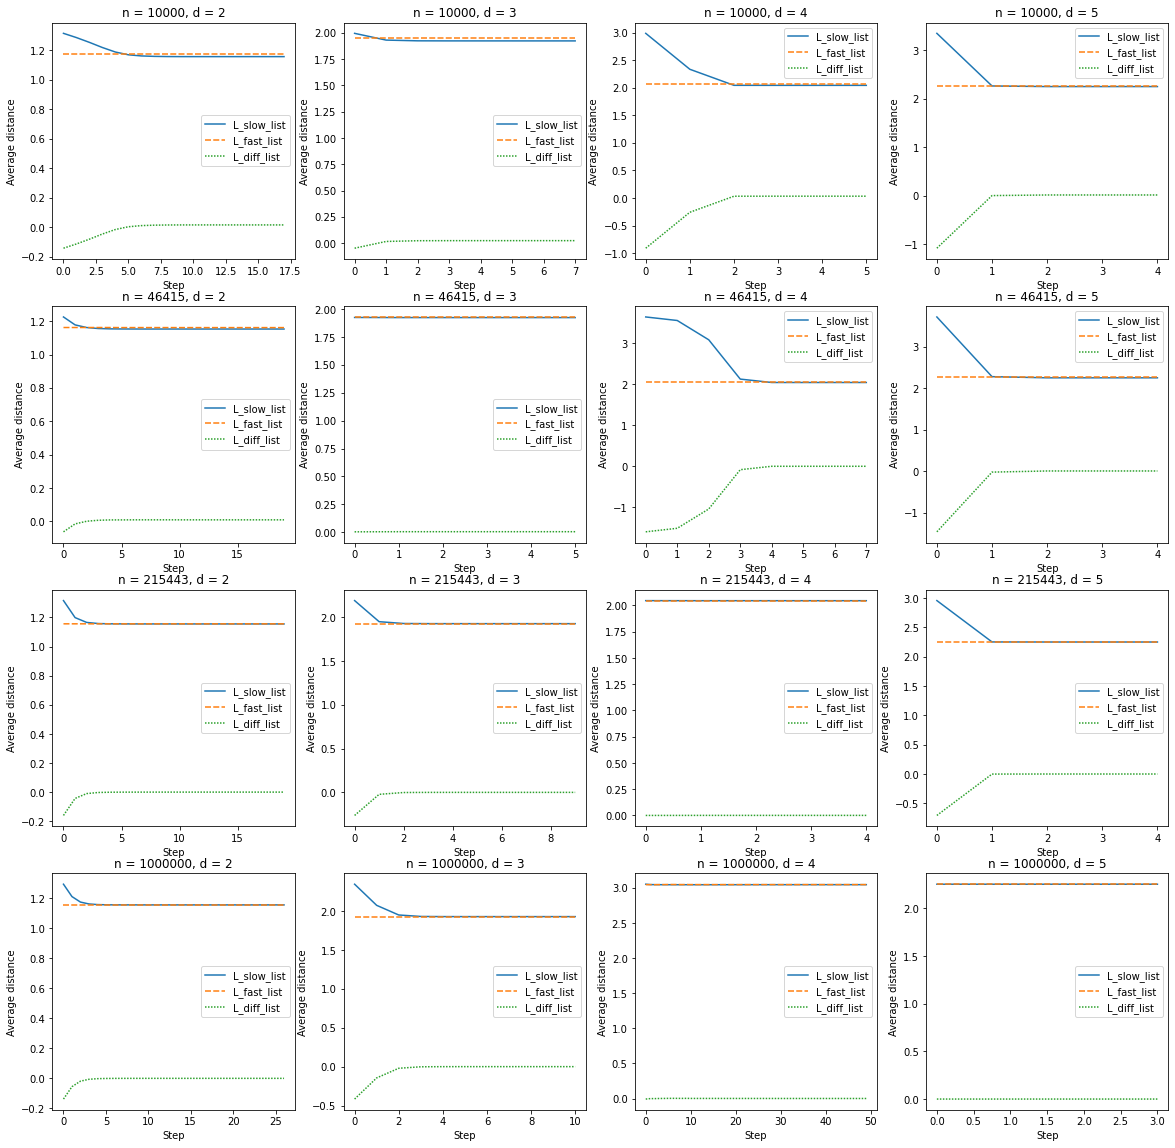

In [156]:
fig, axs = plt.subplots(number_n, number_d, figsize=(20, 20))
for i, n in enumerate(np.logspace(4, 6, num = number_n)):
    for j, d in enumerate(np.arange(number_d) + 2):
        # cast to int
        n = int(n)
        d = int(d)
        # set output path
        path = f'./data/sketching/sketching_2_2_n_{n}_d_{d}.csv'
        
        if run:
            # create synthetic dataset
            true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

            # run KMeans_sketching
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path)
        
        # read .csv
        df = pd.read_csv(path)
        
        # create subplot
        axs[i, j].set_title(f'n = {n}, d = {d}')
        timeseries_plot(df[['L_slow', 'L_fast', 'L_diff']], xlabel='Step', ylabel='Average distance', ax = axs[i, j], show=False)

plt.show()

From the plots we can see how the behaviour remains always the same: sometimes is more accentuated, other times less.

In particular we observe how the `L_fast_list` is constant during the KMeans execution.
This behaviour can be explained by the fact that the fast execution, given the centroids of the slow execution, manages always to converge to its personal solution in `floor(1/subsample_size)` steps.

We can think that this happens because the data distribution of all clusters follows a Gaussian distribution, therefore even with a subset of the datapoints it's easy to find the centroid position, since clusters are well defined.

### 2.2.1 Varying k, k_imposed

We check now if the behaviour of the curves change for different synthetic datasets, with `k` (number of clusters in the dataset) and `k_imposed` (number of clusters imposed to KMeans) varying.

We take:
- `k` in the range [3, 7]
- `k_imposed` in the range [3, 7]

In [200]:
number_k = 4
number_k_imp = 4
seed = 0
n = int(1e5)
d = 3
run = False
subsample_size = 0.01

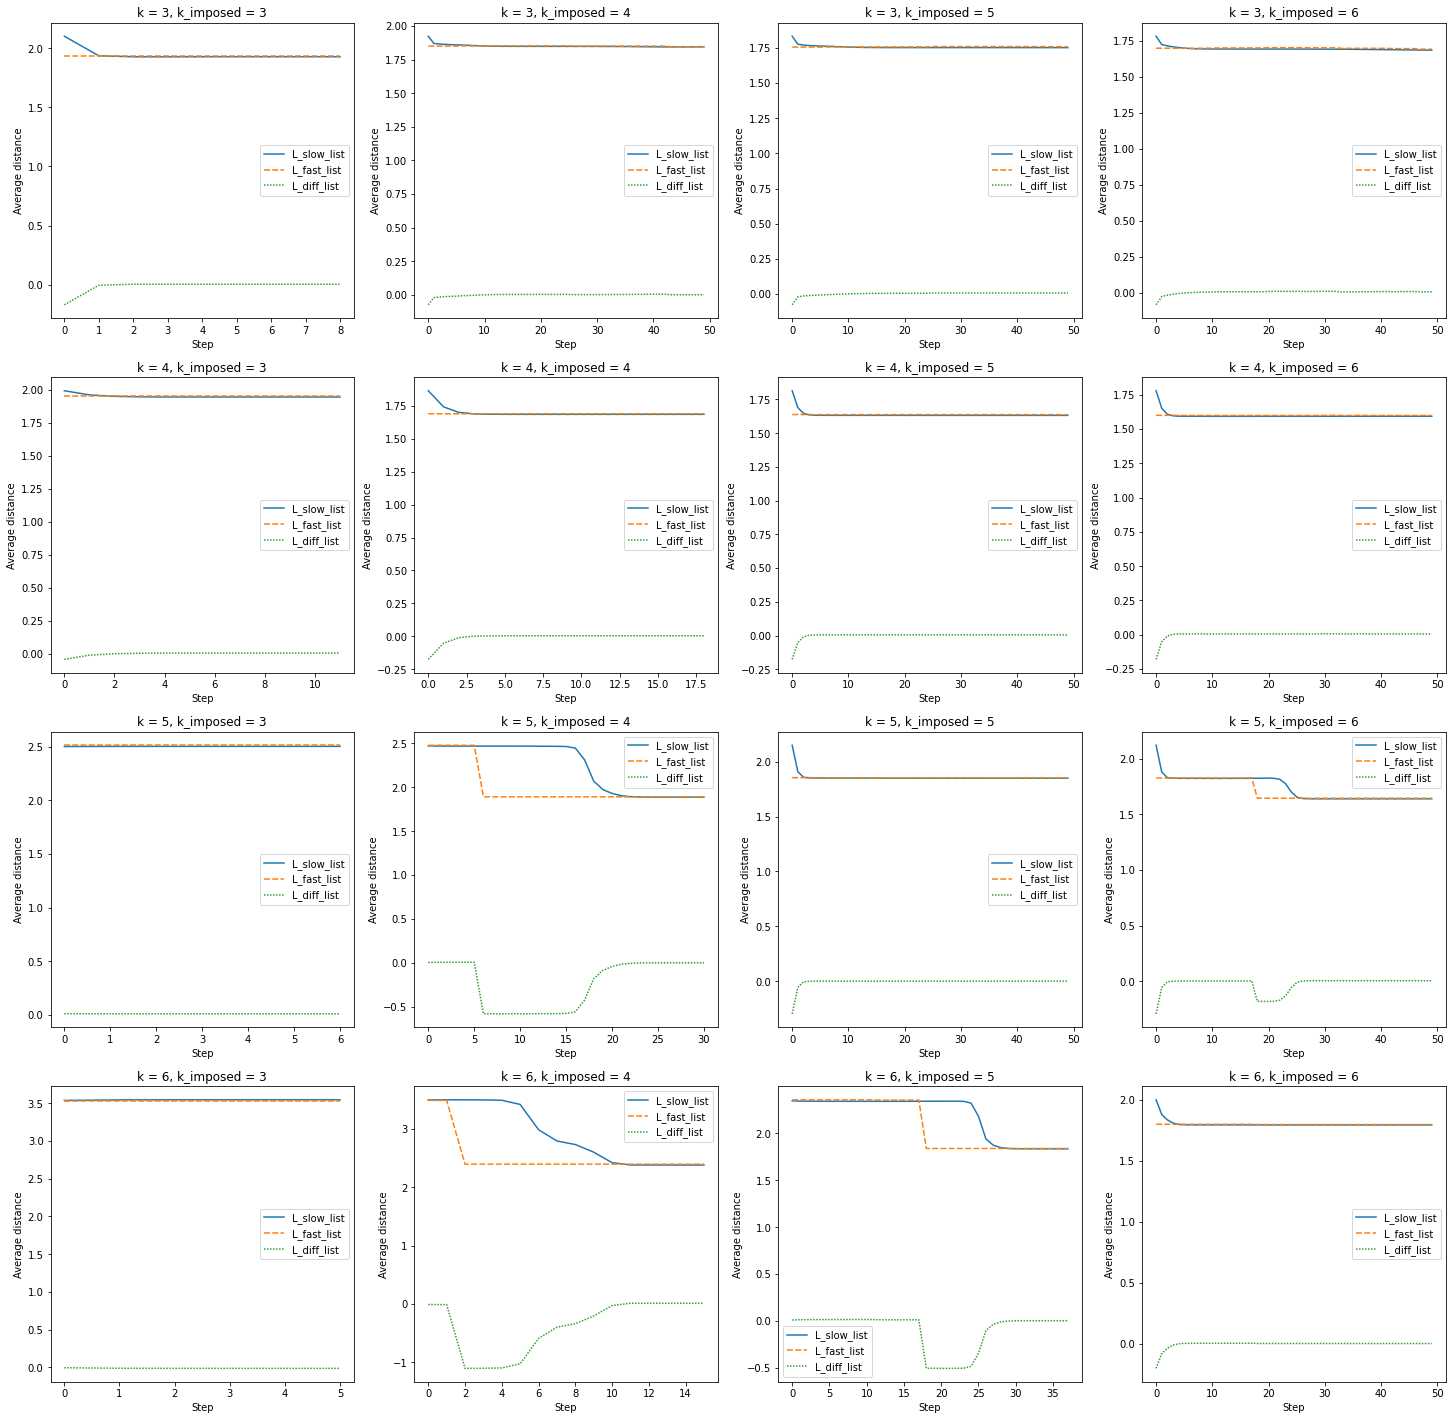

In [201]:
fig, axs = plt.subplots(number_k, number_k_imp, figsize=(25, 25))
for i, k in enumerate(np.arange(number_k) + 3):
    for j, k_imposed in enumerate(np.arange(number_k_imp) + 3):
        # cast to int
        k = int(k)
        k_imposed = int(k_imposed)
        
        # set output path
        path = f'./data/sketching/sketching_2_2_k_{k}_k_imposed_{k_imposed}.csv'
        if run:
            # create synthetic dataset
            true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

            # run KMeans_sketching
            labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path)
        
        # read .csv
        df = pd.read_csv(path)
        
        # create subplot
        axs[i, j].set_title(f'k = {k}, k_imposed = {k_imposed}')
        timeseries_plot(df[['L_slow', 'L_fast', 'L_diff']], xlabel='Step', ylabel='Average distance', ax = axs[i, j], show=False)

plt.show()

In this case we can see dome differences, especially for:
- k = 5, k_imposed = 4
- k = 5, k_imposed = 6
- k = 6, k_imposed = 4

In this plots, we see how `L_fast` is no more constant. However we can see how **in the fast execution, we reduce the value of L earlier than the slow execution.**

## 2.3 Multiple executions - real datasets

We now execute the same code using now real datasets to see if the behaviour stays consistent.

In [205]:
# load datasets
query = "NumberOfInstances > 10000 &\
         NumberOfInstances < 100000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list = load_datasets(query, n_datasets = 10, search = False)

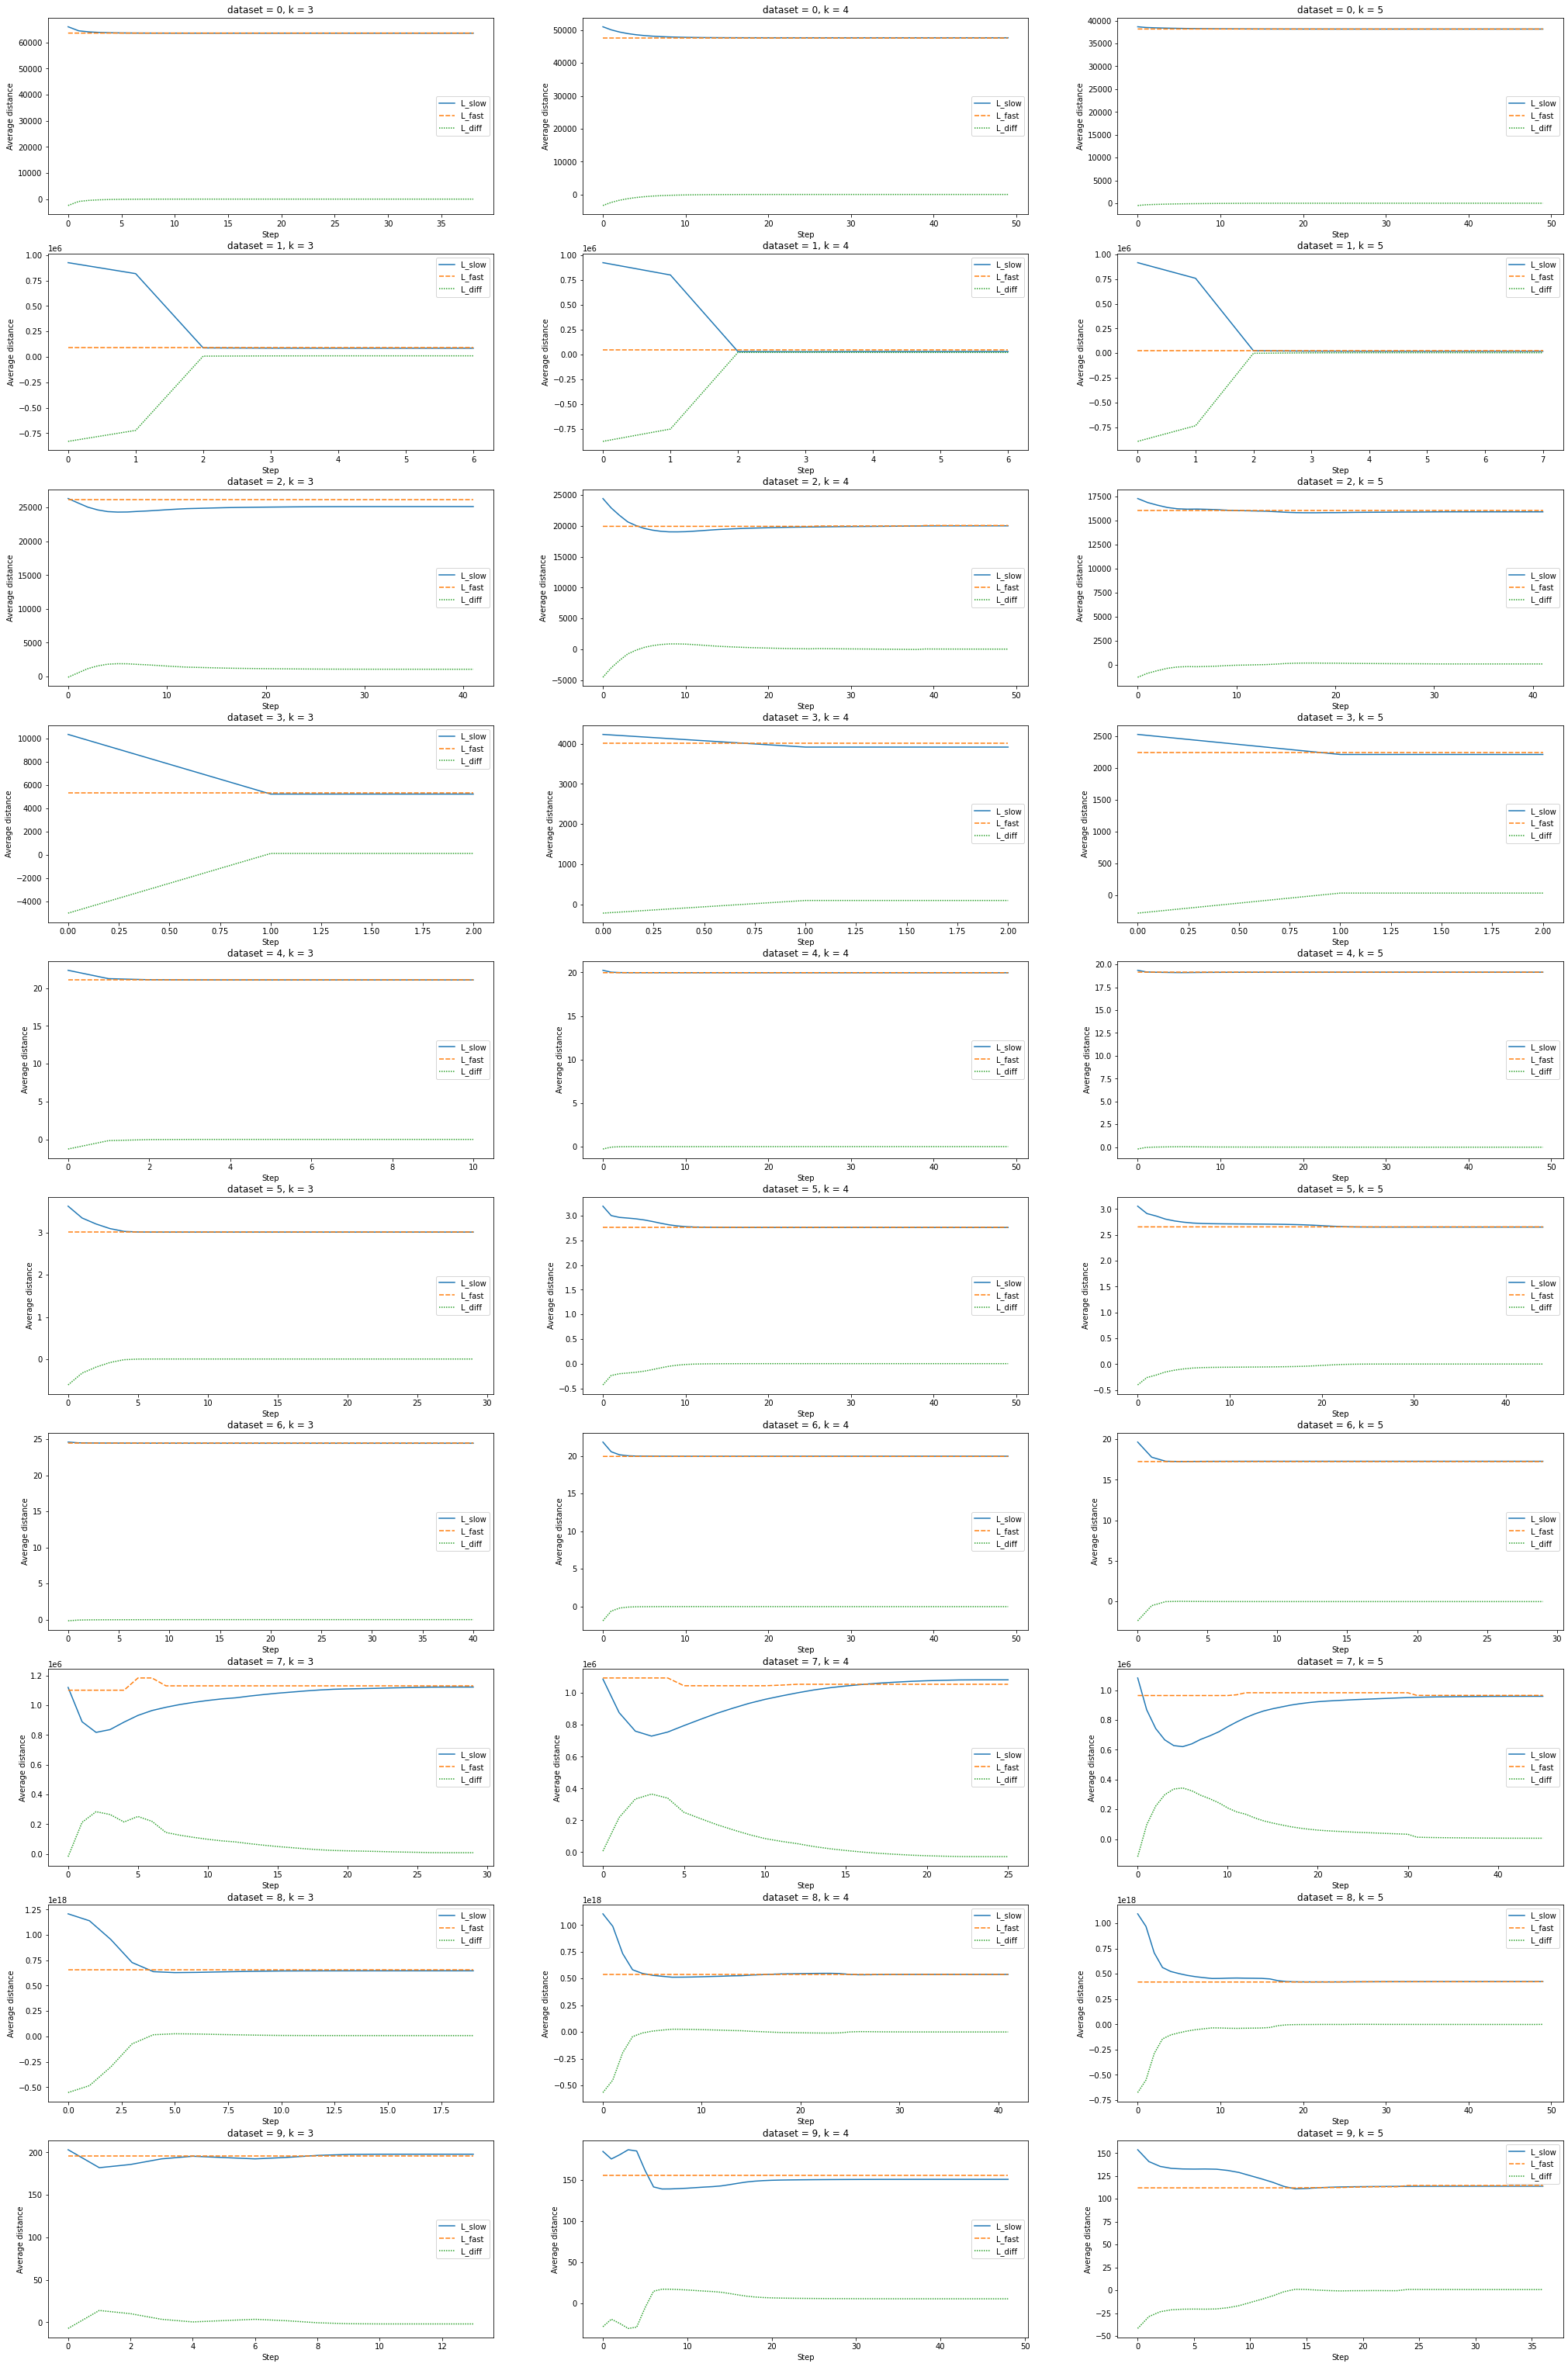

In [228]:
# set seed
seed = 0
subsample_size = 0.01
run = True

fig, axs = plt.subplots(len(X_list), 3, figsize=(35, 55))
for i, X in enumerate(X_list):
    # set parameters
    n, d = X.shape
    for j, k in enumerate(range(3,6)):
        # set output path
        path = f'./data/sketching/sketching_2_3_dataset_{i}_k_{k}.csv'
        if run:            
            # run KMeans_sketching
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path)

        # read .csv
        df = pd.read_csv(path)

        # create subplot
        axs[i, j].set_title(f'dataset = {i}, k = {k}')
        timeseries_plot(df[['L_slow', 'L_fast', 'L_diff']], xlabel='Step', ylabel='Average distance', ax = axs[i, j], show=False)

## Plot

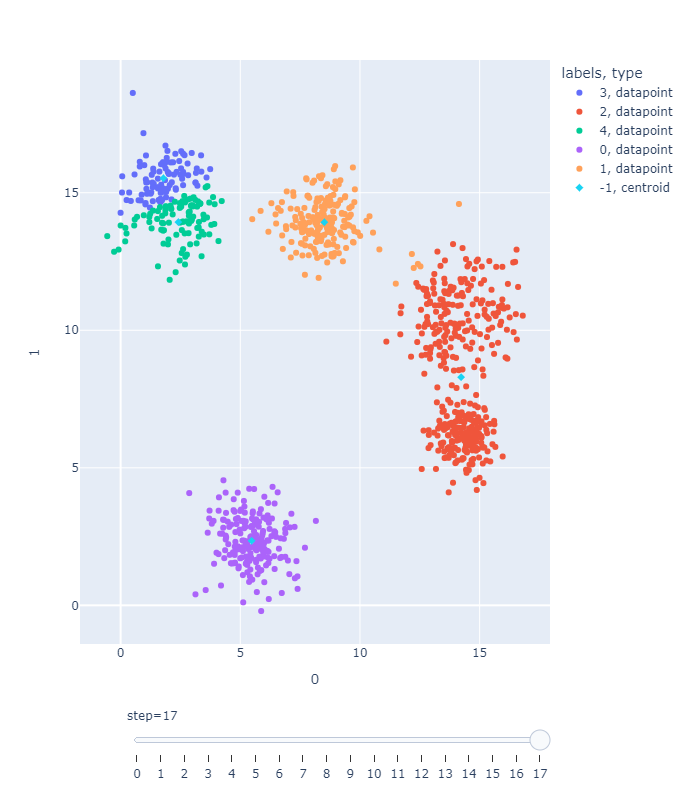

In [67]:
import plotly.express as px

fig = px.scatter(df, x=0, y=1, animation_frame="step", color="labels", symbol ='type', width=800, height=800)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

## import plotly.express as px

fig = px.scatter(df_fast, x=0, y=1, animation_frame="step", color="labels", symbol ='type', width=800, height=800)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [60]:
L_diff_list

array([-0.45872624,  0.58765938,  0.59045245,  0.59045245])